<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:**

Обучить модель классифицировать комментарии на позитивные и негативные. То есть задача определения тональности текста.

**Цель:**

Модель со значением метрики качества *F1* не меньше 0.75. 

**Ход выполнения проекта**

1. Загрузка и подготовка данных.
2. Обучение моделей. 
3. Выводы.

**Описание данных**

Файл `toxic_comments.csv`. 

`text` - текст комментария

`toxic` — целевой признак.

<h3> Импорт библиотек<a class="tocSkip"> </h3>

In [1]:
# Импорт основных библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
import re
import warnings
warnings.filterwarnings('ignore')

try:
    import spacy
except:
    !pip install spacy -q
    import spacy

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, RandomizedSearchCV, HalvingRandomSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgb
from catboost import CatBoostClassifier

import torch
import transformers
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel

from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score

# константы

RANDOM_STATE=42

## Подготовка

In [2]:
# загрузим данные из csv-файла

try: 
    df = pd.read_csv('toxic_comments.csv') 
except: 
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')


In [3]:
# обзор датасета

df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
# информация о датасете

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
# пропуски

df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [6]:
# дубликаты

df.duplicated().sum()

0

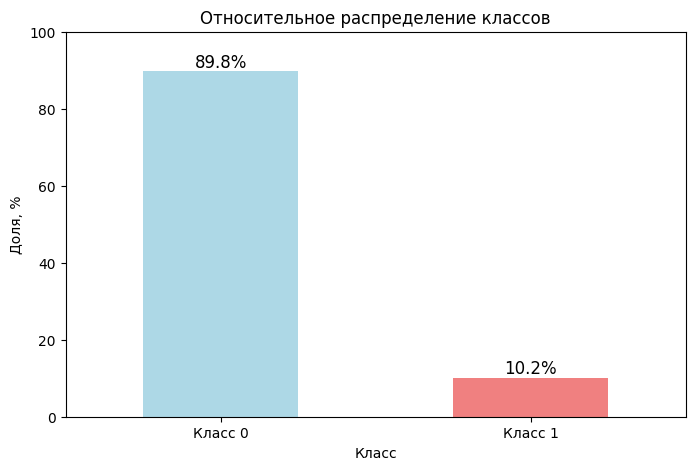

In [7]:
# проверим баланс классов целевого признака

class_distribution = df['toxic'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))

# Построение диаграммы
ax = class_distribution.plot(kind='bar', color=['lightblue', 'lightcoral'])

# Настройки графика
plt.xlabel('Класс')
plt.ylabel('Доля, %')
plt.title('Относительное распределение классов')
plt.xticks(ticks=[0, 1], labels=['Класс 0', 'Класс 1'], rotation=0)
plt.ylim(0, 100)  

# Отображаем процентные значения над столбцами
for i, v in enumerate(class_distribution):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)


Очевидный дисбаланс. Класс 1 составляет всего 10% от всей выборки, поэтому этот класс модель может распознавать в итоге хуже. 
      
Во-первых, будем использовать стратификацию при разделении на тренировочные и валидационные выборки. 
    
Во-вторых, в моделях можно указывать параметр class_weight='balanced', указывая на несбалансированность классов

<h3> Очистка и лемматизация<a class="tocSkip"> </h3>

In [8]:
# функция для очистки текста

def clear_text(text):
    t = re.sub(r'[^a-zA-z]', ' ', text)
    t = t.split()
    t = ' '.join(t)
    return t

df['сlear_text'] = df['text'].apply(clear_text)

In [9]:
# библиотека SpaCy

import subprocess

try:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"]) #исключим ненужные модули для ускорения
except OSError:
    print("Модель не найдена. Загружаем...")
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

print("Модель загружена!")

Модель загружена!


In [10]:
# функция для лемматизации текста с прогрессом

df_1 = pd.DataFrame({'text': ["The cats are running", "Children played outside", "He watches movies"] * 10000})  # 30K строк


def lemmatize_with_progress(texts, data):
    texts = map(str, texts) 
    docs = list(tqdm(nlp.pipe(texts), total=data.shape[0], desc="Лемматизация"))
    return [" ".join([token.lemma_ for token in doc]) for doc in docs]

# Применяем лемматизацию с прогрессом
df_1['lemmatized_text'] = lemmatize_with_progress(df_1['text'], df_1)

# Вывод первых строк
print(df_1.head())

Лемматизация: 100%|█████████████████████| 30000/30000 [00:10<00:00, 2835.06it/s]


                      text     lemmatized_text
0     The cats are running      the cat be run
1  Children played outside  child play outside
2        He watches movies      he watch movie
3     The cats are running      the cat be run
4  Children played outside  child play outside


Функция работает корректно

In [11]:
# выполним лемматизацию текста и добавим новый столбец в наш датасет
df['lemm_text'] = lemmatize_with_progress(df['сlear_text'], df)

df.head()

Лемматизация: 100%|████████████████████| 159292/159292 [12:25<00:00, 213.67it/s]


,Unnamed: 0,text,toxic,сlear_text,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,d aww he match this background colour I m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,hey man I m really not try to edit war it s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,More I can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,you sir be my hero any chance you remember wha...


**ВЫВОД ПО РАЗДЕЛУ "ПОДГОТОВКА":**

Данные состоят из одного датасета, в котором 3 столбца, в одном из них текст комментариев, в другом метка тональности текста (целевой признак)

Пропусков и дубликатов в датасете не выявлено.

Выявлен дисбаланс классов, минорный класс "1" составляет всего 10% от общего числа.

Данные очищены с помощью созданной функции `clear_text` с использованием регулярных выражений `re`.
Текст лемматизирован с помощью библиотеки SpaCy, для ускорения работы исключены модули `parser`, `ner`, `textcat`.

Теперь данные готовы к формированию признаков для модели: разделению на выборки, векторизации и обучению моделей, которое будем осуществлять посредством пайплайна.

## Обучение

<h3> Подготовка признаков<a class="tocSkip"> </h3>

In [12]:
# разделим данные на выборки: тренировочную и тестовую, добавим стратификацию

X = df['lemm_text']
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127433,), (31859,), (127433,), (31859,))

Трансформируем признаки в векторы с помощью величин TF-IDF. Сделаем это в пайплайне.

TF-IDF оценивает важность слова. TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

In [13]:
# Загрузим список стоп-слов, создадим список английских стоп-слов

nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evgeniazigaeva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h3> Логистическая регрессия<a class="tocSkip"> </h3>

Создадим пайплайн для обработки текста с помощью TfidfVectorizer(), исключив стопслова.

In [14]:
pipe_lr = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words=stopwords)),
        ('models', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE))
    ]
)

In [15]:
# Соберем словарь из перебираемых гиперпараметров

param_lr = [
    {
        'models__C': [1, 10, 100],
        'models__penalty': ['l1', 'l2']
    }
]

random_lr = RandomizedSearchCV(
    pipe_lr, 
    param_lr, 
    cv=3,
    scoring='f1',
    verbose=2,
    random_state=RANDOM_STATE,
    error_score='raise',
    n_jobs=-1
)
random_lr.fit(X_train, y_train)

# создадим функцию выдачи результатов
def results(model):
    results = model.cv_results_
    best_index = model.best_index_
    best_score = model.best_score_
    params = results['params'][best_index]
    fit_time = results['mean_fit_time'][best_index]
    predict_time = results['mean_score_time'][best_index]
    return params, best_score, fit_time, predict_time  

params_lr, best_score_lr, fit_time_lr, predict_time_lr = results(random_lr)

print(f"Лучшие параметры: {params_lr}")
print(f"Лучший score: {best_score_lr:.2f}")

# затраченное время
print(f"Время обучения: {fit_time_lr:.2f} сек")
print(f"Время предсказания: {predict_time_lr:.2f} сек")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Лучшие параметры: {'models__penalty': 'l2', 'models__C': 10}
Лучший score: 0.76
Время обучения: 3.55 сек
Время предсказания: 1.26 сек


Лучшие параметры Логистической регрессии l2-регуляризация с силой регуляризации 10.

Метрика F1 равна 0.76, что удовлетворяет заданию (>0.75)

<h3> Multinomial Naive Bayes (MultinomialNB)<a class="tocSkip"> </h3>

In [16]:
pipe_nb = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words=stopwords)),
        ('models', MultinomialNB())
    ]
)

In [17]:
# Соберем словарь из перебираемых гиперпараметров

param_nb = [
    {
        'models__alpha': [0.1, 0.5, 1, 5, 10]
    }
]

random_nb = RandomizedSearchCV(
    pipe_nb, 
    param_nb, 
    cv=3,
    scoring='f1',
    verbose=2,
    random_state=RANDOM_STATE,
    error_score='raise',
    n_jobs=-1
)
random_nb.fit(X_train, y_train)

params_nb, best_score_nb, fit_time_nb, predict_time_nb = results(random_nb)

print(f"Лучшие параметры: {params_nb}")
print(f"Лучший score: {best_score_nb:.2f}")

# затраченное время
print(f"Время обучения: {fit_time_nb:.2f} сек")
print(f"Время предсказания: {predict_time_nb:.2f} сек")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Лучшие параметры: {'models__alpha': 0.1}
Лучший score: 0.63
Время обучения: 2.15 сек
Время предсказания: 1.21 сек


Лучшие параметры модели Наивный Байес alpha=0.1.

Метрика F1 равна 0.63, что не удовлетворяет заданию (>0.75)

<h3> RandomForestClassifier (Случайный лес)<a class="tocSkip"> </h3>

In [18]:
pipe_rf = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words=stopwords)),
        ('models', RandomForestClassifier(random_state=RANDOM_STATE))
    ]
)

In [19]:
# Соберем словарь из перебираемых гиперпараметров

param_rf = {
    'models__n_estimators': [50, 100], 
    'models__max_depth': [None, 10, 20], 
    'models__min_samples_split': [2, 5, 10], 
    'models__min_samples_leaf': [2, 5], 
}

random_rf = RandomizedSearchCV(
    pipe_rf, 
    param_rf, 
    cv=3,
    scoring='f1',
    verbose=2,
    random_state=RANDOM_STATE,
    error_score='raise',
    n_jobs=-1
)
random_rf.fit(X_train, y_train)

params_rf, best_score_rf, fit_time_rf, predict_time_rf = results(random_rf)

print(f"Лучшие параметры: {params_rf}")
print(f"Лучший score: {best_score_rf:.2f}")

# затраченное время
print(f"Время обучения: {fit_time_rf:.2f} сек")
print(f"Время предсказания: {predict_time_rf:.2f} сек")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры: {'models__n_estimators': 50, 'models__min_samples_split': 5, 'models__min_samples_leaf': 5, 'models__max_depth': None}
Лучший score: 0.52
Время обучения: 8.14 сек
Время предсказания: 1.95 сек


Эта модель отработала еще хуже. Лучшие параметры модели Случайный лес Количество деревьев=50, Глубина деревьев не ограничена, Минимальное количество выборок для разбиения=5, Минимальное количество выборок в листе=5

Метрика F1 равна 0.52, что не удовлетворяет заданию (>0.75)

<h3> Бустинговая модель LGBMClassifier<a class="tocSkip"> </h3>

In [20]:
pipe_gbm = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words=stopwords)),
        ('models', lgb.LGBMClassifier( 
    max_depth=5,
    num_leaves=31,
    learning_rate=0.1,
    subsample=0.8,
    random_state=RANDOM_STATE,
    force_col_wise=True,
    verbose=-1
))
    ]
)

In [21]:
# Соберем словарь из перебираемых гиперпараметров

param_gbm = {
    'models__n_estimators': [100, 200, 300],
    'models__max_depth': [-1, 5],
    'models__num_leaves': [10, 20, 30]
}

random_gbm = RandomizedSearchCV(
    pipe_gbm, 
    param_gbm, 
    cv=3,
    scoring='f1',
    verbose=1,
    random_state=RANDOM_STATE,
    error_score='raise',
    n_jobs=1,
    n_iter=3
)

random_gbm.fit(X_train, y_train)

params_gbm, best_score_gbm, fit_time_gbm, predict_time_gbm = results(random_gbm)

print(f"Лучшие параметры: {params_gbm}")
print(f"Лучший score: {best_score_gbm:.2f}")

# затраченное время
print(f"Время обучения: {fit_time_gbm:.2f} сек")
print(f"Время предсказания: {predict_time_gbm:.2f} сек")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Лучшие параметры: {'models__num_leaves': 30, 'models__n_estimators': 300, 'models__max_depth': -1}
Лучший score: 0.77
Время обучения: 10.75 сек
Время предсказания: 1.73 сек


Найдены лучшие параметры модели LGBM.
Метрика F1 равна 0.77, что удовлетворяет заданию (>0.75)

<h3> BERT "unitary/toxic-bert"<a class="tocSkip"> </h3>

BERT - модель для обработки текста, которую можно использовать для создания эмбеддингов (векторных признаков) и последующей классификации.

In [22]:
# Загружаем предобученный AutoTokenizer()

model_name = "unitary/toxic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [23]:
# Переводим модель в режим предсказания (выключаем градиенты)

model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [24]:
# функция для создания эмбеддингов

def get_bert_embedding(text):
    # Токенизация текста (обрезаем до 128 токенов)
    tokens = tokenizer(text, padding="max_length", truncation=True, return_tensors="pt", max_length=128)

    # Передаём текст в BERT и отключаем градиенты (ускоряет работу)
    with torch.no_grad():
        output = model(**tokens)

    # Используем эмбеддинг [CLS] токена (размерность 768)
    return output.last_hidden_state[:, 0, :].numpy()

Ввиду того, что датасет у нас достаточно массивный, а обработка bert ресурсоемка, выберем из датасета только 10000 случайных текстов с длиной сообщения не более 300

In [25]:
# возьмем семпл

df['len'] = df['text'].str.len()
df_bert = df[df['len']<200]
df_bert = df_bert.sample(n=10000, random_state=RANDOM_STATE)
df_bert = df_bert[['text', 'toxic']]
df_bert

,text,toxic
72865,"""The artcile assert notability - """"famous"""" - ...",0
145991,GO AND FUCK WIKIPEDIA...WHO THE HELL CARES...,1
66188,I hate you. U are a homosapian. Breasts,1
97345,"""\n\n Capitalization \n\nThe capitalization of...",0
122145,(I think kororima (which I thought might be ca...,0
...,...,...
27766,Bing Bang (Time to Dance)\nWhat do you feel ne...,0
70000,You love the devil and worship him.,1
80391,Purpose phrases ==\n A linguistic source about...,0
105575,So my band's not notable? Try telling that all...,0


In [26]:
# проверим соотношение классов в целевой переменной

class_distribution = df_bert['toxic'].value_counts(normalize=True) * 100
class_distribution

toxic
0    86.33
1    13.67
Name: proportion, dtype: float64

In [27]:
# Преобразуем тексты в эмбеддинги

X = np.array([get_bert_embedding(text) for text in df_bert['text']])
y = df_bert['toxic'].values  # Метки

# Убираем лишнее измерение
X = X.squeeze()

print("Размер X:", X.shape)  
print("Размер y:", y.shape)  

[CV] END ....................models__C=1, models__penalty=l2; total time=   4.2s
[CV] END ..................models__C=100, models__penalty=l1; total time=   7.0s
[CV] END ..................................models__alpha=0.1; total time=   3.4s
[CV] END ...................................models__alpha=10; total time=   3.0s
[CV] END models__max_depth=10, models__min_samples_leaf=2, models__min_samples_split=2, models__n_estimators=100; total time=   5.4s
[CV] END models__max_depth=20, models__min_samples_leaf=5, models__min_samples_split=2, models__n_estimators=50; total time=   4.7s
[CV] END models__max_depth=10, models__min_samples_leaf=2, models__min_samples_split=2, models__n_estimators=50; total time=   4.4s
[CV] END ....................models__C=1, models__penalty=l1; total time=   4.1s
[CV] END ...................models__C=10, models__penalty=l2; total time=   4.6s
[CV] END ....................................models__alpha=1; total time=   3.4s
[CV] END models__max_depth=20, model

In [28]:
# Разделяем данные на train/test

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [29]:
pipe_bert = Pipeline(
    [
        ('models', LogisticRegression())
    ]
)

In [30]:
# Соберем словарь из перебираемых гиперпараметров

params = [
    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100],
        'models__max_depth': [None, 10]

    },
    
    # словарь для модели LGBM()
    {
        'models': [lgb.LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300],
        'models__max_depth': [-1, 5]
    },
    
     # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)],
        'models__C': [1, 10, 100],
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear']
    }
]

random_bert = RandomizedSearchCV(
    pipe_bert, 
    params, 
    cv=3,
    scoring='f1',
    verbose=2,
    random_state=RANDOM_STATE,
    error_score='raise',
    n_jobs=1,
    n_iter=3
)

random_bert.fit(X_train_bert, y_train_bert)

params_bert, best_score_bert, fit_time_bert, predict_time_bert = results(random_bert)

print(f"Лучшие параметры: {params_bert}")
print(f"Лучший score: {best_score_bert:.2f}")

# затраченное время
print(f"Время обучения: {fit_time_bert:.2f} сек")
print(f"Время предсказания: {predict_time_bert:.2f} сек")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=None, models__n_estimators=50; total time=   2.6s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=None, models__n_estimators=50; total time=   2.2s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=None, models__n_estimators=50; total time=   2.3s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=None, models__n_estimators=100; total time=   5.2s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=None, models__n_estimators=100; total time=   4.4s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=None, models__n_estimators=100; total time=   4.8s
[CV] END models=LGBMClassifier(random_state=42), models__max_depth=-1, models__n_estimators=200; total time=   2.0s
[CV] END models=LGBMClassifier(random_state=42), models__max_depth=-1, m

Метрика после обработка текста с библиотекой unitary/toxic-bert впечатляет.
Метрика F1 равна 0.97, что удовлетворяет заданию (>0.75)

<h3> BERT базовая<a class="tocSkip"> </h3>

BERT - попробуем базовую библиотеку

In [31]:
# Загружаем предобученный BERT

model_base = "bert-base-uncased"
tokenizer_base = BertTokenizer.from_pretrained(model_base)
model_base = BertModel.from_pretrained(model_base)

In [32]:
# Переводим модель в режим предсказания (выключаем градиенты)

model_base.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [33]:
# функция для создания эмбеддингов

def get_bert_base_embedding(text):
    # Токенизация текста (обрезаем до 128 токенов)
    tokens = tokenizer_base(text, padding="max_length", truncation=True, return_tensors="pt", max_length=128)

    # Передаём текст в BERT и отключаем градиенты (ускоряет работу)
    with torch.no_grad():
        output = model_base(**tokens)

    # Используем эмбеддинг [CLS] токена (размерность 768)
    return output.last_hidden_state[:, 0, :].numpy()

Ввиду того, что датасет у нас достаточно массивный, а обработка bert ресурсоемка, выберем из датасета только 10000 случайных текстов с длиной сообщения не более 300

In [34]:
# Преобразуем тексты в эмбеддинги

X_base = np.array([get_bert_base_embedding(text) for text in df_bert['text']])
y_base = df_bert['toxic'].values  # Метки

# Убираем лишнее измерение
X_base = X_base.squeeze()

print("Размер X:", X_base.shape)  
print("Размер y:", y_base.shape)  

Размер X: (10000, 768)
Размер y: (10000,)


In [35]:
# Разделяем данные на train/test

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [36]:
pipe_base = Pipeline(
    [
        ('models', LogisticRegression())
    ]
)

In [37]:
# Соберем словарь из перебираемых гиперпараметров

params = [
    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100],
        'models__max_depth': [None, 10]

    },
    
    # словарь для модели LGBM()
    {
        'models': [lgb.LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300],
        'models__max_depth': [-1, 5]
    },
    
     # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)],
        'models__C': [1, 10, 100],
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear']
    }
]

random_base = RandomizedSearchCV(
    pipe_base, 
    params, 
    cv=3,
    scoring='f1',
    verbose=2,
    random_state=RANDOM_STATE,
    error_score='raise',
    n_jobs=1,
    n_iter=3
)

random_base.fit(X_train_base, y_train_base)

params_base, best_score_base, fit_time_base, predict_time_base = results(random_base)

print(f"Лучшие параметры: {params_base}")
print(f"Лучший score: {best_score_base:.2f}")

# затраченное время
print(f"Время обучения: {fit_time_base:.2f} сек")
print(f"Время предсказания: {predict_time_base:.2f} сек")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=None, models__n_estimators=50; total time=   4.0s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=None, models__n_estimators=50; total time=   3.9s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=None, models__n_estimators=50; total time=   4.2s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=None, models__n_estimators=100; total time=   8.0s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=None, models__n_estimators=100; total time=   7.9s
[CV] END models=RandomForestClassifier(random_state=42), models__max_depth=None, models__n_estimators=100; total time=   8.0s
[CV] END models=LGBMClassifier(random_state=42), models__max_depth=-1, models__n_estimators=200; total time=   3.4s
[CV] END models=LGBMClassifier(random_state=42), models__max_depth=-1, m

Метрика после обработка текста с базовой библиотекой BERT неудовлетворительна.
Метрика F1 равна 0.66, что не удовлетворяет заданию (>0.75)

<h3> Итоги<a class="tocSkip"> </h3>

In [38]:
# сравнение метрик моделей

data = {
    'Model': ['LogisticRegression', 'MultinomialNB', 'RandomForest', 'LightGBM', 'BERT+RandomForest', 'BERT_base+LGBM'],
    'fit_time': [fit_time_lr, fit_time_nb, fit_time_rf, fit_time_gbm, fit_time_bert, fit_time_base],
    'predict_time': [predict_time_lr, predict_time_nb, predict_time_rf, predict_time_gbm, predict_time_bert, predict_time_base],
    'f1': [best_score_lr, best_score_nb, best_score_rf, best_score_gbm, best_score_bert, best_score_base]
}

# Создаём DataFrame
df_results = pd.DataFrame(data)
df_results.set_index('Model', inplace=True)
df_results.sort_values('f1', ascending=False)

,fit_time,predict_time,f1
Model,,,
BERT+RandomForest,4.767160,0.015086,0.965248
LightGBM,10.754857,1.733990,0.774333
LogisticRegression,3.549488,1.259758,0.761848
BERT_base+LGBM,3.417952,0.007821,0.659410
MultinomialNB,2.145118,1.212143,0.627882
RandomForest,8.144620,1.949615,0.521674


BERT с библиотекой unitary/toxic-bert показала лучший результат.
Проверим метрику на тесте.

In [39]:
# Оцениваем на тестовых данных

y_test_pred = random_bert.predict(X_test_bert)

print(f'Метрика f1 на тестовой выборке: {f1_score(y_test_bert, y_test_pred):.2f}')

Метрика f1 на тестовой выборке: 0.96


## Выводы

Поставлена задача построения модели для прогноза тональности текста.

*Ход работы:*

1. Загрузка данных и подготовка.

В данных пропусков и дубликатов не обнаружено. 
Обнаружен дисбаланс классов. Класс 1 составляет всего 10% от всей выборки, поэтому этот класс модель может распознавать в итоге хуже.
Решено использовать стратификацию при разделении на тренировочные и валидационные выборки.

Подготовка данных осуществлена двумя методами:
- с лемматизацией с помощью библиотеки SpaCy
- с моделью BERT, использующую создание эмбендингов

2. Обучение моделей с лемматизированными признаками.

Для обучения моделей текст был очищен от лишних символов и лемматизирован, т.е. все слова приведены к их начальной форме.

Данные были разделены на выборки тренировочную и тестовую (20%)
Создан пайплайн с предварительной трансформацией признаков в векторы с помощью величин TF-IDF.

Обучено 4 модели и получены метрики `f1` с лучшими гиперпараметрами на кросс-валидации: 

- Логистическая регрессия - 0.77
- Наивный Байес - 0.63
- Случайный лес  - 0.53
- модель градиентного бустинга LightGBM - 0.77

3. Обучение моделей с BERT.

Для трансформации текста в эмбендинги были опробованы две библиотеки BERT `unitary/toxic-bert` и `bert-base-uncased`, мы только предсказываем на уже предобученных моделях. 

Ввиду того, что датасет у нас достаточно массивный, а обработка bert ресурсоемка, решено взять семпл на 10000 текстов с длиной сообщения не более 300.

Готовые эмбендинги разделены на выборки тренировочную (80%) и тестовую (20%).
С помощью `RandomizedSearchCV` осуществлен подбор лучшей модели с лучшими параметрами среди:
- Логистическая регрессия
- Случайный лес
- модель градиентного бустинга LightGBM

Результат лучшей метрики с библиотекой `unitary/toxic-bert` оказался отличным 0.97, когда как базовая библиотека дала метрику `f1` 0.66.

4. Проверка данных на тестовой выборке.

Лучшей метрикой на кросс-валидации обладает модель BERT с использованием библиотеки `unitary/toxic-bert`. 

При тестировании этой модели на тестовых данных получена метрика `f1` равная 0.96, удовлетворяющая порогу задания >0.75.
